In [ ]:
!gdown 1zw0eQrXrjMh0tOerPoTgOVN9hYLa69eJ

Downloading...
From (original): https://drive.google.com/uc?id=1zw0eQrXrjMh0tOerPoTgOVN9hYLa69eJ
From (redirected): https://drive.google.com/uc?id=1zw0eQrXrjMh0tOerPoTgOVN9hYLa69eJ&confirm=t&uuid=c8c8ca89-2b46-4f50-b9d3-07cc47d941cf
To: /content/Unet.h5
100% 373M/373M [00:03<00:00, 98.5MB/s]


In [ ]:
!gdown 1-FI-g0yoDfQrmignkDkGBNp5zzvVCbUu

Downloading...
From (original): https://drive.google.com/uc?id=1-FI-g0yoDfQrmignkDkGBNp5zzvVCbUu
From (redirected): https://drive.google.com/uc?id=1-FI-g0yoDfQrmignkDkGBNp5zzvVCbUu&confirm=t&uuid=d4d83325-e47c-4f60-9f5b-004d6a9c46d4
To: /content/DeepLabv3.h5
100% 139M/139M [00:01<00:00, 89.5MB/s]


In [ ]:
from tensorflow.keras.models import load_model

model1 = load_model("Unet.h5")
model2 = load_model("DeepLabv3.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


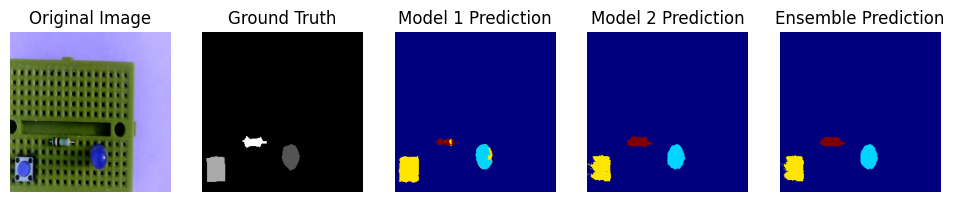

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(image, true_mask):
    pred1 = np.argmax(model1.predict(np.expand_dims(image, axis=0)), axis=-1)[0]
    pred2 = np.argmax(model2.predict(np.expand_dims(image, axis=0)), axis=-1)[0]
    combined_pred = ensemble_predict(image)

    # Convert ground truth from one-hot to class labels (if necessary)
    if len(true_mask.shape) == 3 and true_mask.shape[-1] > 1:
        true_mask = np.argmax(true_mask, axis=-1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 5, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 5, 2)
    plt.imshow(true_mask, cmap="gray")  # Ensure correct format
    plt.axis("off")
    plt.title("Ground Truth")

    plt.subplot(1, 5, 3)
    plt.imshow(pred1, cmap="jet")  # Use color map to show differences
    plt.axis("off")
    plt.title("Model 1 Prediction")

    plt.subplot(1, 5, 4)
    plt.imshow(pred2, cmap="jet")
    plt.axis("off")
    plt.title("Model 2 Prediction")

    plt.subplot(1, 5, 5)
    plt.imshow(combined_pred, cmap="jet")
    plt.axis("off")
    plt.title("Ensemble Prediction")

    plt.show()

# Test visualization on a sample image
idx=9
visualize_results(X_val[idx], y_val[idx])


In [ ]:
import numpy as np

def ensemble_predict(image):
    pred1 = model1.predict(np.expand_dims(image, axis=0))
    pred2 = model2.predict(np.expand_dims(image, axis=0))

    combined_pred = (pred1 + pred2) / 2
    finalmask = np.argmax(combined_pred, axis=-1)[0]

    return finalmask


In [ ]:
def evaluate_ensemble(X_val, y_val):
    correct1, correct2, correct_combined = 0, 0, 0
    total_pixels = 0  # Track total pixels across all images

    for img, true_mask in zip(X_val, y_val):
        true_mask = np.argmax(true_mask, axis=-1)  # Ensure (H, W)

        pred1 = np.argmax(model1.predict(np.expand_dims(img, axis=0)), axis=-1)[0]
        pred2 = np.argmax(model2.predict(np.expand_dims(img, axis=0)), axis=-1)[0]
        combined_pred = ensemble_predict(img)

        # Flatten all for comparison
        true_mask = true_mask.flatten()
        pred1 = pred1.flatten()
        pred2 = pred2.flatten()
        combined_pred = combined_pred.flatten()

        # Compute pixel-wise accuracy
        correct1 += np.sum(pred1 == true_mask)
        correct2 += np.sum(pred2 == true_mask)
        correct_combined += np.sum(combined_pred == true_mask)
        total_pixels += true_mask.size

    acc1 = correct1 / total_pixels
    acc2 = correct2 / total_pixels
    acc_combined = correct_combined / total_pixels

    print(f"Model 1 Accuracy: {acc1:.4f}")
    print(f"Model 2 Accuracy: {acc2:.4f}")
    print(f"Ensemble Accuracy: {acc_combined:.4f}")

# Run evaluation
evaluate_ensemble(X_val, y_val)

In [ ]:
!gdown 1NGN-p46EP5_So_7pKX3qJ0cg0VeryA38
!unzip UNET-PCB.zip

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os

# Paths
image_dir = "/content/UNET-PCB/img"
mask_dir = "/content/UNET-PCB/mask"

IMG_SIZE = (256, 256)

def load_data(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

    images, masks = [], []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE) / 255.0
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
        masks.append(mask)
        images.append(img)

    return np.array(images), np.array(masks)

# Load dataset
images, masks = load_data(image_dir, mask_dir)

masks = tf.keras.utils.to_categorical(masks, num_classes=4)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)